In [111]:
#importing modules
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import datetime
import time
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import os

In [80]:
#Changing working directory
os.chdir(r'D:\Coding\projects\Palak_Paneer')
os.getcwd()

'D:\\Coding\\projects\\Palak_Paneer'

In [81]:
#loading the final train dataset
df_full = pd.read_csv(r"train_datasets\train_clean_full.csv")
print(df_full.shape)
df_full.head()

(891, 20)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,tot_fam,female,male,C,Q,S,pclass_1,pclass_2,pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,1,0,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1,0,0,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,1,0,0,0,1,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0,1,0,0,1,0,0,1


In [82]:
#making dummies for interaction effects
df_full['fem_1'] = 0
df_full.loc[(df_full['female']==1)&(df_full['pclass_1']==1), 'fem_1'] = 1

df_full['fem_2'] = 0
df_full.loc[(df_full['female']==1)&(df_full['pclass_2']==1), 'fem_2'] = 1

df_full['fem_3'] = 0
df_full.loc[(df_full['female']==1)&(df_full['pclass_3']==1), 'fem_3'] = 1

df_full['male_1'] = 0
df_full.loc[(df_full['male']==1)&(df_full['pclass_1']==1), 'male_1'] = 1

df_full['male_2'] = 0
df_full.loc[(df_full['male']==1)&(df_full['pclass_2']==1), 'male_2'] = 1

df_full['male_3'] = 0
df_full.loc[(df_full['male']==1)&(df_full['pclass_3']==1), 'male_3'] = 1

In [83]:
#QC
df_full[['Sex', 'Pclass', 'fem_1', 'fem_2', 'fem_3', 'male_1', 'male_2', 'male_3']].head()
#pass

,Sex,Pclass,fem_1,fem_2,fem_3,male_1,male_2,male_3
0,male,3,0,0,0,0,0,1
1,female,1,1,0,0,0,0,0
2,female,3,0,0,1,0,0,0
3,female,1,1,0,0,0,0,0
4,male,3,0,0,0,0,0,1


In [84]:
#QC
df_full['interaction_QC']=df_full['fem_1'] + df_full['fem_2'] + df_full['fem_3'] + df_full['male_1'] + df_full['male_2'] + df_full['male_3']
print(df_full[df_full['interaction_QC']==1].shape)
df_full[df_full['interaction_QC']!=1].head()
#pass

(891, 27)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,pclass_1,pclass_2,pclass_3,fem_1,fem_2,fem_3,male_1,male_2,male_3,interaction_QC


#### Applying random forest

In [85]:
#breaking down into X and y arrays, removing categorical vars - these vars(except Name) have already been made into booleans: train
X = df_full.drop(['Survived','Name','Sex','Ticket','Embarked','Pclass','male','Parch', 'SibSp','PassengerId','interaction_QC'], axis = 1)
y = pd.DataFrame(df_full['Survived'])
print(X.shape)
print(y.shape)
#X.head()

(891, 16)
(891, 1)


In [86]:
#train, dev split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.05)

In [87]:
#random forest - main
clf=RandomForestClassifier(n_estimators=200, min_samples_split = 20, min_samples_leaf= 15, oob_score = True, criterion = 'entropy'
                          ,max_depth = 10, min_impurity_decrease = 0.004)
clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10,
                       min_impurity_decrease=0.1, min_samples_leaf=15,
                       min_samples_split=20, n_estimators=200, oob_score=True)

In [ ]:
#grid search for hyper parameter tuning
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 500, 1000, 1200, 2000],
    'max_features': ['auto', 'sqrt', 'log2', 'int'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy'],
    'min_samples_split' :[2,4,5,6,8,10,12,15,20],
    'min_samples_leaf':[3,5,8,10,12,15,17,20],
    'min_impurity_decrease': list(range(0.001,0.1,0.02))}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

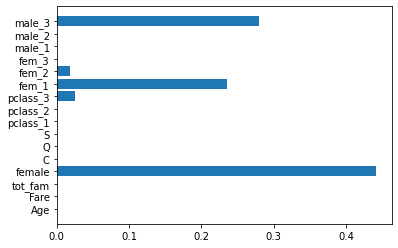

In [88]:
#feature importance
plt.barh(X_train.columns, clf.feature_importances_)
plt.show()

In [89]:
print('Accuracy Score on train: ', clf.score(X_train, y_train))
print('Accuracy Score on oob data: ', clf.oob_score_)

Accuracy Score on train:  0.7872340425531915
Accuracy Score on oob data:  0.7884160756501182


In [90]:
#prediction y for dev data 
y_pred_dev=clf.predict(X_dev)

In [91]:
#converts from df to numpy
y_dev = y_dev['Survived'].to_numpy()
y_dev

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0], dtype=int64)

    0   1
0  25   7
1   3  10


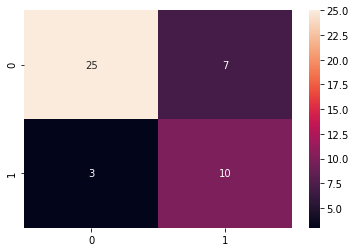

In [92]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_dev, y_pred_dev, labels=[0,1]))
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)

In [93]:
#calculating accuracy and other scores
accuracy_dev = metrics.accuracy_score(y_dev, y_pred_dev)
print('accuracy is: '+ str(accuracy_dev))
precision_dev = metrics.precision_score(y_dev, y_pred_dev)
print('precision is: '+ str(precision_dev))
sensitivity_dev = metrics.recall_score(y_dev, y_pred_dev)
print('sensitivity is: '+ str(sensitivity_dev))
f1_score_dev = metrics.f1_score(y_dev, y_pred_dev)
print('f1_score is: '+ str(f1_score_dev))

accuracy is: 0.7777777777777778
precision is: 0.5882352941176471
sensitivity is: 0.7692307692307693
f1_score is: 0.6666666666666667


## Test pipeline-predicts and creates submission csv

### Loading the final test dataset

In [94]:
#loading test dataset
X_test = pd.read_csv(r"test_datasets/test_clean_full.csv")
print(X_test.shape)
X_test.head()

(418, 19)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,tot_fam,female,male,C,Q,S,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,0,1,0,1,0,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1,1,0,0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,0,1,0,1,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,0,1,0,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,2,1,0,0,0,1,0,0,1


In [95]:
#making dummies for interaction effects
X_test['fem_1'] = 0
X_test.loc[(X_test['female']==1)&(X_test['pclass_1']==1), 'fem_1'] = 1

X_test['fem_2'] = 0
X_test.loc[(X_test['female']==1)&(X_test['pclass_2']==1), 'fem_2'] = 1

X_test['fem_3'] = 0
X_test.loc[(X_test['female']==1)&(X_test['pclass_3']==1), 'fem_3'] = 1

X_test['male_1'] = 0
X_test.loc[(X_test['male']==1)&(X_test['pclass_1']==1), 'male_1'] = 1

X_test['male_2'] = 0
X_test.loc[(X_test['male']==1)&(X_test['pclass_2']==1), 'male_2'] = 1

X_test['male_3'] = 0
X_test.loc[(X_test['male']==1)&(X_test['pclass_3']==1), 'male_3'] = 1

In [96]:
#QC
X_test[['Sex', 'Pclass', 'fem_1', 'fem_2', 'fem_3', 'male_1', 'male_2', 'male_3']].head()
#pass

,Sex,Pclass,fem_1,fem_2,fem_3,male_1,male_2,male_3
0,male,3,0,0,0,0,0,1
1,female,3,0,0,1,0,0,0
2,male,2,0,0,0,0,1,0
3,male,3,0,0,0,0,0,1
4,female,3,0,0,1,0,0,0


In [97]:
#QC
X_test['interaction_QC']=X_test['fem_1'] + X_test['fem_2'] + X_test['fem_3'] + X_test['male_1'] + X_test['male_2'] + X_test['male_3']
print(X_test[X_test['interaction_QC']==1].shape)
X_test[X_test['interaction_QC']!=1].head()
#pass

(418, 26)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,pclass_1,pclass_2,pclass_3,fem_1,fem_2,fem_3,male_1,male_2,male_3,interaction_QC


In [98]:
#breaking down into X and y arrays, removing categorical vars - these vars(except Name) have already been made into booleans: train
X_test = X_test.drop(['Name','Sex','Ticket','Embarked','Pclass','male','Parch', 'SibSp','PassengerId','interaction_QC'], axis = 1)
print(X_test.shape)
print(X.shape)
#X.head()

(418, 16)
(891, 16)


In [99]:
print(X_train.columns)
print(X_test.columns)

Index(['Age', 'Fare', 'tot_fam', 'female', 'C', 'Q', 'S', 'pclass_1',
       'pclass_2', 'pclass_3', 'fem_1', 'fem_2', 'fem_3', 'male_1', 'male_2',
       'male_3'],
      dtype='object')
Index(['Age', 'Fare', 'tot_fam', 'female', 'C', 'Q', 'S', 'pclass_1',
       'pclass_2', 'pclass_3', 'fem_1', 'fem_2', 'fem_3', 'male_1', 'male_2',
       'male_3'],
      dtype='object')


### Predicting on the amended test dataset and preparing the file for submission

In [100]:
#prediction y for dev data 
y_pred_test=clf.predict(X_test)

In [101]:
#reading a submission csv and then using it's passenger id
pid_array = pd.read_csv(r'submission\csv_submission20210529230942.csv')
pid_array.shape
#pid_array.head()

(418, 2)

In [102]:
#subsetting only the Passenger Id column for final submission 
X_concat = pid_array[['PassengerId']]
X_concat.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [103]:
#creating final submission csv
y_pred_test_df = pd.DataFrame(y_pred_test)
y_pred_test_df.rename(columns = {0:'Survived'},inplace = True)
csv_submission = pd.merge(X_concat,y_pred_test_df, left_index=True, right_index=True)
print(csv_submission.shape)
csv_submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [104]:
#saving csv with a unique timestamp
timestamp = str(datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
timestamp
csv_submission.to_csv(r'submission\csv_submission' + timestamp + '.csv', index =False)